## Семинар 4: "Сверточные сети"

ФИО: 

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(signal.shape[0]-kernel.shape[0]+1)
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.dot(signal[i:i+kernel.shape[0]], kernel[::-1])
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

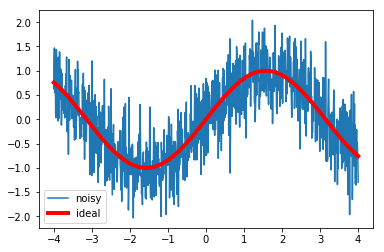

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [5]:
kernel = np.ones(71)
kernel /= kernel.shape[0]

denoised_signal = convolve(noisy_signal, kernel, 'same')

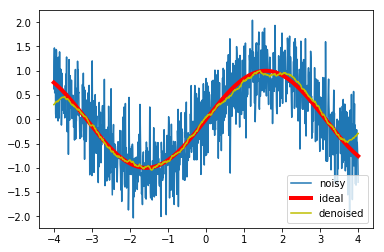

In [6]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [7]:
for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    
    print("ks = {}, error = {}".format(size, error))

ks = 3, error = 0.08154701783107032
ks = 5, error = 0.04868904236211874
ks = 7, error = 0.03480519745023822
ks = 9, error = 0.02641131257048089
ks = 11, error = 0.02081596476135496
ks = 13, error = 0.017030774025646678
ks = 15, error = 0.014265706120141428
ks = 17, error = 0.01236008513420304
ks = 19, error = 0.010998456977722837
ks = 21, error = 0.010113121825960249
ks = 23, error = 0.009475255505533171
ks = 25, error = 0.009101448268929741
ks = 27, error = 0.008768854612816096
ks = 29, error = 0.008501837290730091
ks = 31, error = 0.008369305378742602
ks = 33, error = 0.008235276108956944
ks = 35, error = 0.00808589987559349
ks = 37, error = 0.007946912321137848
ks = 39, error = 0.007813708985431581
ks = 41, error = 0.007749947782291359
ks = 43, error = 0.007661830677397286
ks = 45, error = 0.007579993361752565
ks = 47, error = 0.007533660413491098
ks = 49, error = 0.007560694607273176
ks = 51, error = 0.00761627270070795
ks = 53, error = 0.007683047653302951
ks = 55, error = 0.00773

ks = 433, error = 0.13726673192616226
ks = 435, error = 0.13864161598304187
ks = 437, error = 0.14002558388424408
ks = 439, error = 0.14141765677178755
ks = 441, error = 0.14281663203746636
ks = 443, error = 0.1442197070492854
ks = 445, error = 0.14562460614189796
ks = 447, error = 0.14703302484064
ks = 449, error = 0.14844200045535016
ks = 451, error = 0.14985706413141509
ks = 453, error = 0.15127625604562067
ks = 455, error = 0.15269741317004962
ks = 457, error = 0.1541233757671652
ks = 459, error = 0.15555761533348292
ks = 461, error = 0.15699396968762047
ks = 463, error = 0.15843950098054388
ks = 465, error = 0.1598874791290387
ks = 467, error = 0.1613356452738642
ks = 469, error = 0.16278755452671134
ks = 471, error = 0.1642467829807142
ks = 473, error = 0.16571407392300952
ks = 475, error = 0.16718714714703475
ks = 477, error = 0.16866655690280405
ks = 479, error = 0.17015114083763114
ks = 481, error = 0.17163676048009877
ks = 483, error = 0.17312392573829868
ks = 485, error = 0.

ks = 869, error = 0.4367584721398533
ks = 871, error = 0.4375573480453951
ks = 873, error = 0.43835009056486207
ks = 875, error = 0.4391340087012963
ks = 877, error = 0.4399089335535084
ks = 879, error = 0.44067520676239724
ks = 881, error = 0.4414336540274602
ks = 883, error = 0.4421816608178016
ks = 885, error = 0.44292278776986976
ks = 887, error = 0.4436538604503711
ks = 889, error = 0.444374579688357
ks = 891, error = 0.44508841790117926
ks = 893, error = 0.4457922118360618
ks = 895, error = 0.44648903511686044
ks = 897, error = 0.4471786915175824
ks = 899, error = 0.4478616352514347
ks = 901, error = 0.44853969999955323
ks = 903, error = 0.4492093355760976
ks = 905, error = 0.44987341372885964
ks = 907, error = 0.45053016803826734
ks = 909, error = 0.4511784438726031
ks = 911, error = 0.451819701690957
ks = 913, error = 0.45245153313061376
ks = 915, error = 0.45307510024419095
ks = 917, error = 0.4536929256651734
ks = 919, error = 0.45430235961607246
ks = 921, error = 0.454905877

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [8]:
image = plt.imread('image.jpg')

In [9]:
image.shape

(278, 501, 3)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [10]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

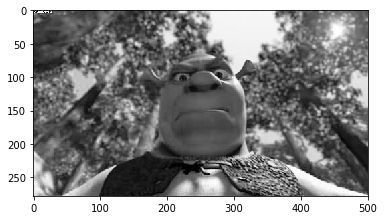

In [11]:
bw_image = convolve(image.flatten(), color_to_bw, 'same')[::3].reshape(*image.shape[:2])
convolve(noisy_signal, kernel, 'same')
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [12]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

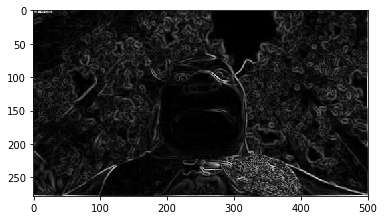

In [13]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [14]:
#[10, 30, 3] -> [10, 30, 4]
#[3, 3, 3, 4]

def t_convolve_bank(signal, kernel):
    assert signal.shape[-1] == kernel.shape[0]
    
    res = []
    for i in range(kernel.shape[-1]):
        r = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            r += convolve2d(signal[:, :, j], kernel[j, :, :, i], 'same')            
        
        res.append(r)
    
    return np.array(res).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [15]:
#RGB -> RBG

kernels = np.zeros((3, 1, 1, 3))

kernels[0, 0, 0, 2] = 1
kernels[1, 0, 0, 1] = 1
kernels[2, 0, 0, 0] = 1

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

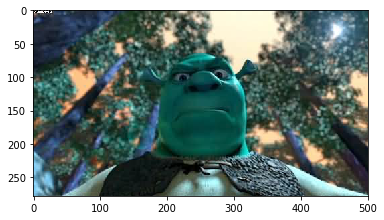

In [16]:
res_image = t_convolve_bank(image.astype(float), kernels)
plt.imshow(res_image.astype('uint8'))

# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [17]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0] - w, w):
        for j in range(0, image.shape[1] - w, w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])  
    return res

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0] - w, w):
        for j in range(0, image.shape[1] - w, w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
    return res

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

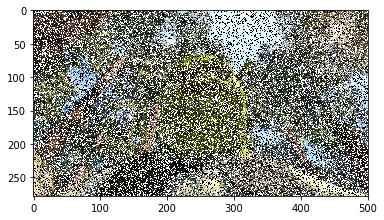

In [18]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

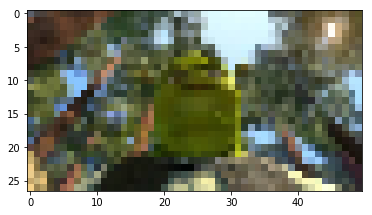

In [19]:
clean_image = medianpool(res_image.astype(float), 10)
plt.imshow(clean_image.astype('uint8'))

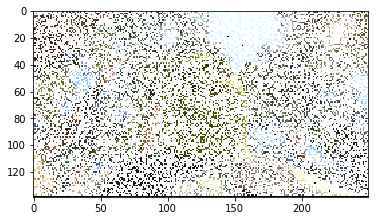

In [20]:
res_image = maxpool(res_image.astype(float))
plt.imshow(res_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Лучше справился медианный пулинг, потому что он учитывает все значения пикселей в некотором радиусе в отличие от максимального пулинга, учитывающего только максимальное значение в некоторой области.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [21]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [22]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [23]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.227/0.210	Accuracy: 0.934/0.940


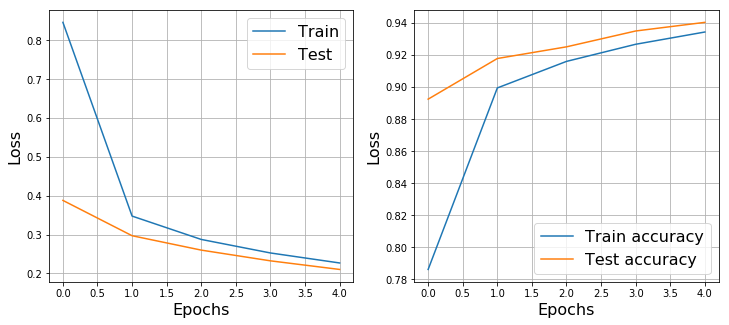

In [24]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [25]:
class ConvClassifier_1(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, (3, 3), padding=1), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (3, 3), padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.079/0.065	Accuracy: 0.977/0.980


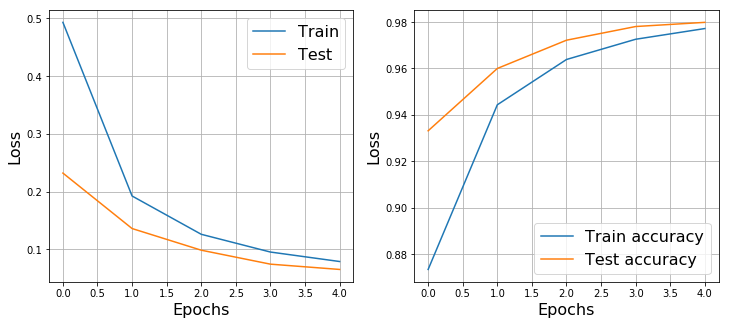

In [26]:
network_1 = ConvClassifier_1(image_size=28)
train(network_1, 5, 1e-4)

In [27]:
class ConvClassifier_2(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, (3, 3), padding=1), nn.ReLU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.060/0.053	Accuracy: 0.982/0.983


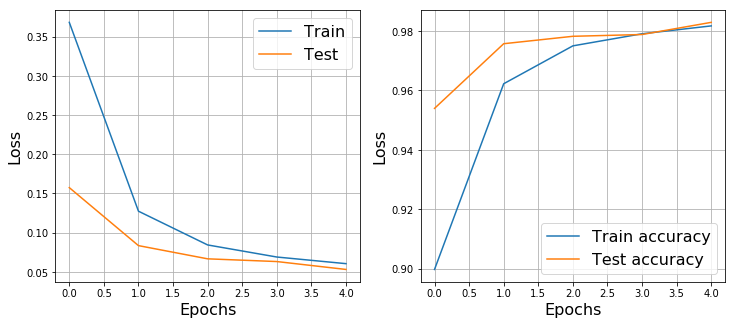

In [28]:
network_2 = ConvClassifier_2(image_size=28)
train(network_2, 5, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [29]:
def print_worst(count_of_bad_predictions, loader, network, loss=nn.NLLLoss()):
    losses = []
    accuracies = []
    list_X = []
    list_y = []
    
    for X, y in s_test_loader:
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        list_X.append(X)
        list_y.append(y[0])
        
    data_y = np.array(list_y)
    losses = np.array(losses)
    
    ind = losses.argsort()[-count_of_bad_predictions:]
    worst_targets = data_y[ind]
    worst_X = []

    for index in ind:
        worst_X.append(list_X[index].numpy())
    worst_X = np.array(worst_X)
    
    worst_predictions = []
    worst_images = np.zeros((count_of_bad_predictions, 784))

    for index in ind:
        worst_predictions.append(np.argmax(network.forward(list_X[index]).data.numpy(), 1))

    worst_images[np.arange(count_of_bad_predictions), :] = worst_X[np.arange(count_of_bad_predictions), 
                                                                   0].reshape(count_of_bad_predictions, 784)
    
    plt.figure(figsize=(16, 17))
    for i in range(count_of_bad_predictions):
        plt.subplot(4, 3, i+1)
        plt.imshow(worst_images[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title("true: %s        pred: %s" % (str(worst_targets[i]), str(worst_predictions[i][0])))
        plt.axis('off')

In [30]:
new_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

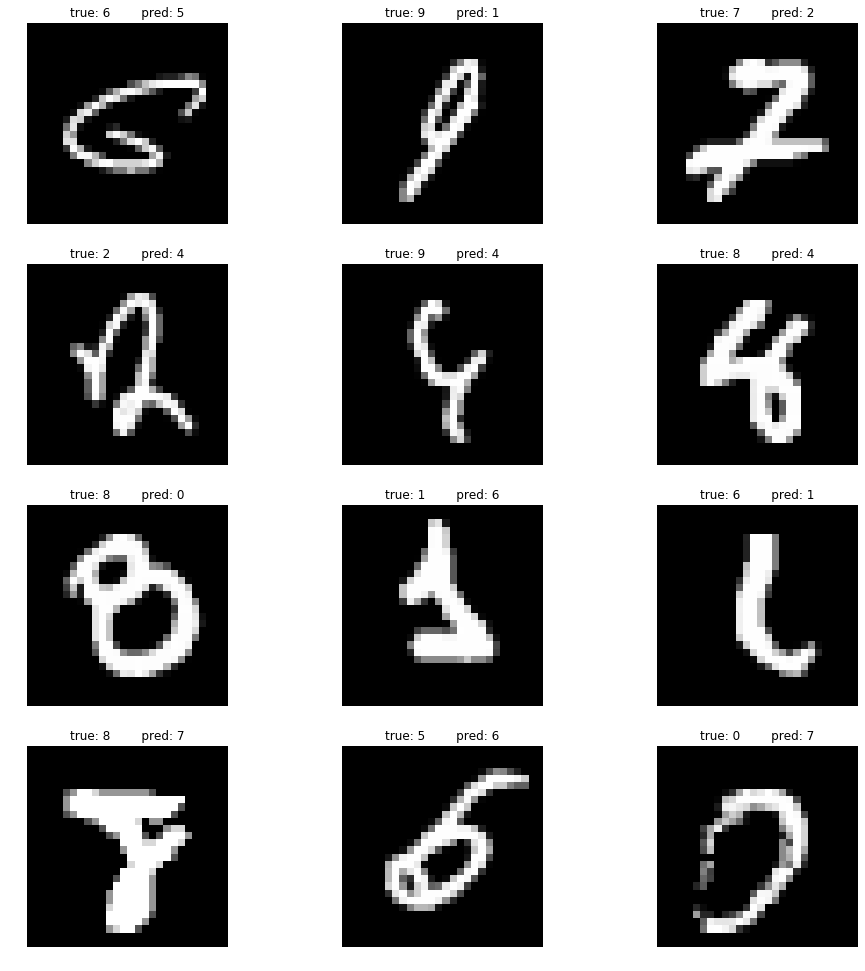

In [31]:
print_worst(12, new_test_loader, network_1, nn.NLLLoss())

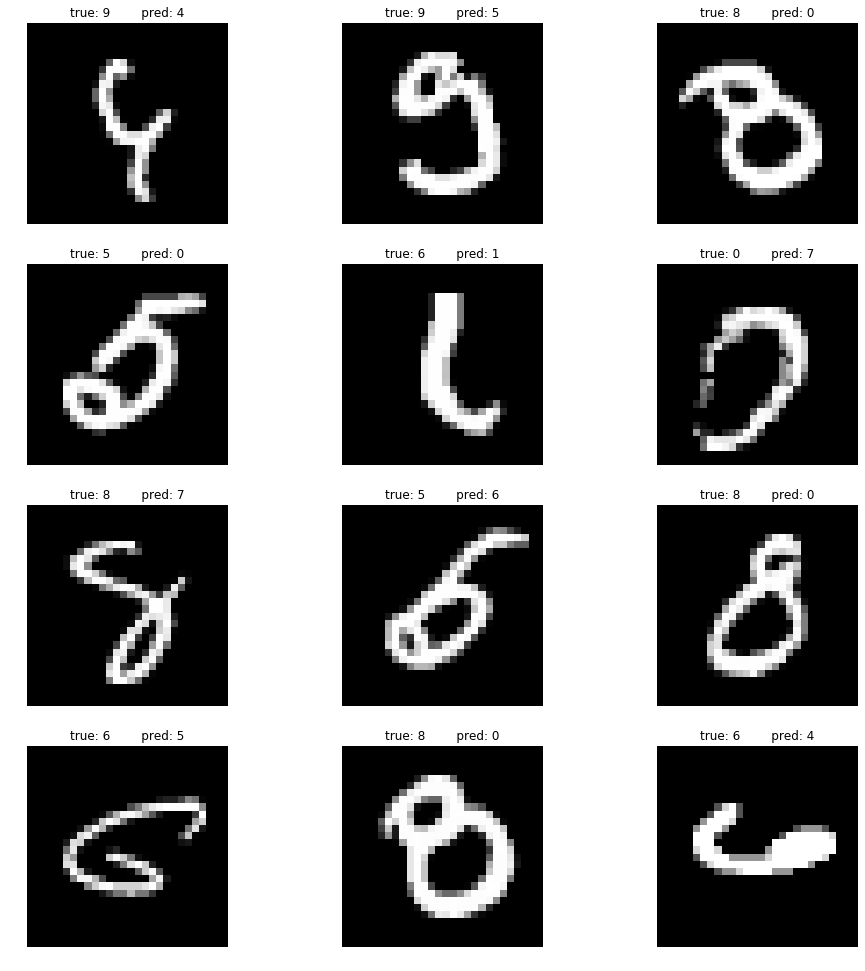

In [32]:
print_worst(12, new_test_loader, network_2, nn.NLLLoss())

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [33]:
class ConvClassifier_3(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 2, (3, 3), padding=1), nn.ReLU(),
                                         nn.Conv2d(2, 4, (3, 3), padding=1), nn.ReLU(),
                                         nn.Conv2d(4, 8, (3, 3), padding=1), nn.ReLU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.092/0.078	Accuracy: 0.972/0.975


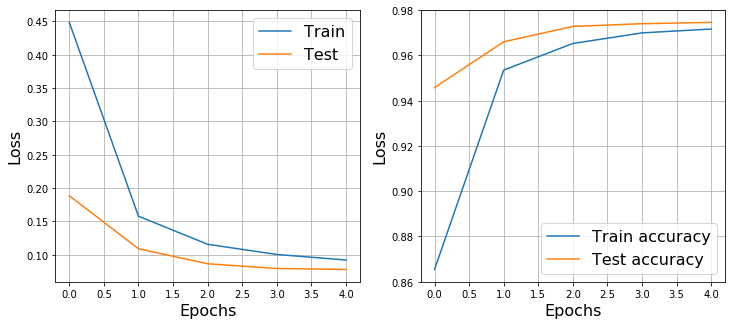

In [34]:
network_3 = ConvClassifier_3(image_size=28)
train(network_3, 5, 1e-4)

In [35]:
class ConvClassifier_4(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, (3, 3), padding=1), nn.ELU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1), nn.ELU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1), nn.ELU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(32, 64, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.052/0.047	Accuracy: 0.984/0.984


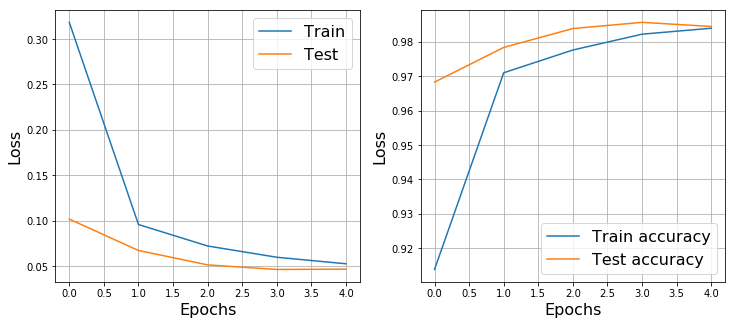

In [36]:
network_4 = ConvClassifier_4(image_size=28)
train(network_4, 5, 1e-4)

In [37]:
class ConvClassifier_5(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 4, (3, 3), padding=1), nn.Tanh(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(4, 8, (3, 3), padding=1), nn.Tanh(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.347/0.321	Accuracy: 0.898/0.906


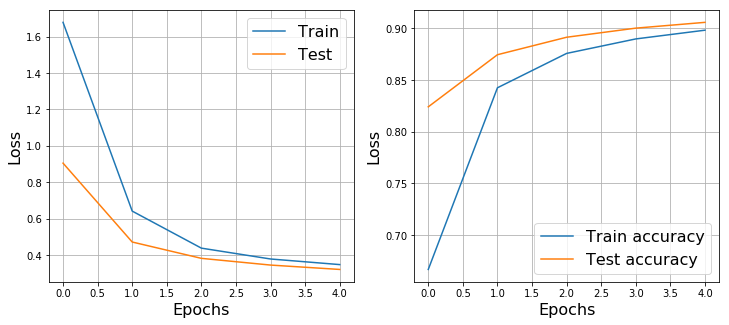

In [38]:
network_5 = ConvClassifier_5(image_size=28)
train(network_5, 5, 1e-5)

Epoch 9... (Train/Test) NLL: 0.042/0.073	Accuracy: 0.987/0.977


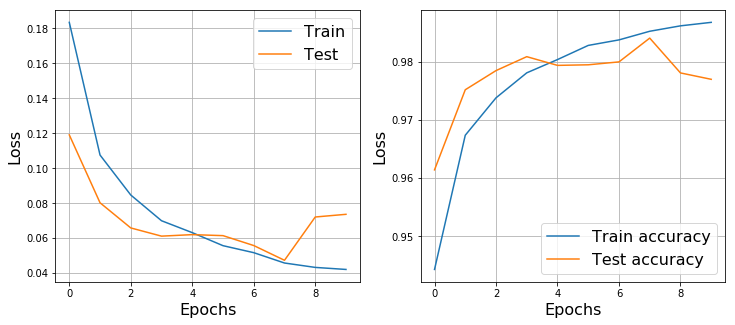

In [39]:
network_6 = ConvClassifier_4(image_size=28)
train(network_5, 10, 1e-3)

Результат удалось улучшить нейронной сетью с архитектурой:

input -> 8 Conv 3x3 -> ELU -> 16 Conv 3x3 -> maxpool -> 32 Conv 3x3 -> ELU -> maxpool -> 64 Conv 3x3 -> ravel -> Linear ->LogSoftmax

(Train/Test) NLL: 0.052/0.047

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: